In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Pullover  Trouser  Dress  Sneaker


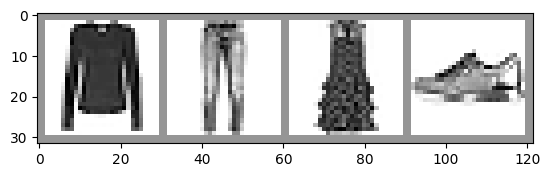

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [4]:
from garmet_classifier import GarmentClassifier
model = GarmentClassifier()

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.1391, 0.8484, 0.1043, 0.7050, 0.6119, 0.9323, 0.5405, 0.6481, 0.3596,
         0.8263],
        [0.0864, 0.4319, 0.3798, 0.4639, 0.3382, 0.1129, 0.3429, 0.4465, 0.7963,
         0.7181],
        [0.1832, 0.1353, 0.6272, 0.1519, 0.8473, 0.0796, 0.9574, 0.2577, 0.2524,
         0.3878],
        [0.8052, 0.1223, 0.8515, 0.8210, 0.9262, 0.0071, 0.4805, 0.7373, 0.2753,
         0.4972]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.35874605178833


In [6]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.9553532818704844
  batch 2000 loss: 0.880671726115048
  batch 3000 loss: 0.6855721101760864
  batch 4000 loss: 0.6297904770867899
  batch 5000 loss: 0.5712974646375515
  batch 6000 loss: 0.5397724162542726
  batch 7000 loss: 0.5345310263386928
  batch 8000 loss: 0.5057191539946944
  batch 9000 loss: 0.4958624095623381
  batch 10000 loss: 0.4744921769860666
  batch 11000 loss: 0.45098201604478527
  batch 12000 loss: 0.4409969382506679
  batch 13000 loss: 0.43525199667038394
  batch 14000 loss: 0.40792582858260723
  batch 15000 loss: 0.4053225284876535
LOSS train 0.4053225284876535 valid 0.4306533634662628
EPOCH 2:
  batch 1000 loss: 0.38647133174428017
  batch 2000 loss: 0.37128184009285176
  batch 3000 loss: 0.39891113736236
  batch 4000 loss: 0.38583572522574106
  batch 5000 loss: 0.36771292916999665
  batch 6000 loss: 0.3879746929961257
  batch 7000 loss: 0.3622489263066673
  batch 8000 loss: 0.34504427706546265
  batch 9000 loss: 0.3582754692625604
  ba

torch.Size([4, 1, 28, 28])


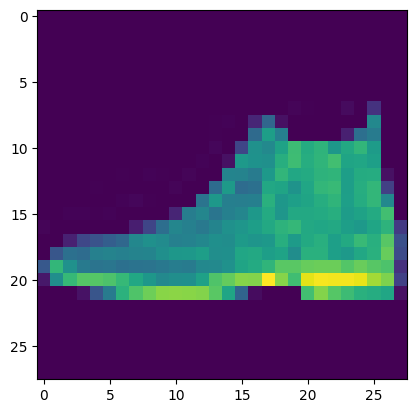

In [35]:
import cv2

for inputs,labels in validation_loader:

    arr: np.ndarray = inputs[0].numpy()
    print(inputs.shape)
    break

image = (arr.reshape(28,28) + 1) * 128

cv2.imwrite("shoe.jpg", image)
plt.imshow(image)